# HW08: Making Python faster

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

In [2]:
# Libraries
%matplotlib inline
%load_ext Cython

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from numba import jit, vectorize, float64, int64

**Functions to optimize**

In [2]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

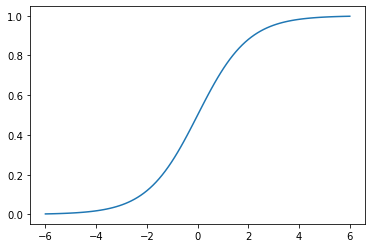

In [3]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

**Data set for classification**

In [4]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

**Using gradient descent for classification by logistic regression**

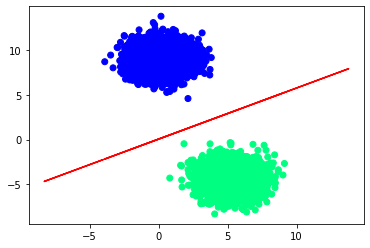

In [5]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. (10 points)

In [6]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [7]:
%timeit logistic(x)

239 ms ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# Note: can also use 1/(1+exp(-x)), which doesn't use any more memory
def logistic1(x):
    x = np.exp(x)
    return x/(1 + x)

In [9]:
%timeit logistic1(x)

177 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**2**. (20 points) Use `numba` to compile the gradient descent function. 

- Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)
- For each function, check that the answers are the same as with the original logistic function using  `np.testing.assert_array_almost_equal`. Use `%timeit` to compare the three logistic functions (5 points)
- Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)
- Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [10]:
# Vectorized version of the logistic function
@vectorize([float64(float64)], target="cpu")
def logistic_numba_cpu(x):
    return 1/(1+np.exp(-x))

In [11]:
# Check for correctness
np.testing.assert_array_almost_equal(logistic(x), logistic_numba_cpu(x))

In [12]:
# Vectorized version runtime
%timeit logistic_numba_cpu(x)

63.7 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
# Parallel vectorized version of logistic function
@vectorize([float64(float64)], target="parallel")
def logistic_numba_parallel(x):
    return 1/(1+np.exp(-x))

In [14]:
# Check for correctness
np.testing.assert_array_almost_equal(logistic(x), logistic_numba_parallel(x))

In [15]:
# Parallel version runtime
%timeit logistic_numba_parallel(x)

102 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
# Note: providing types give annoying errors, so I'm going to skip that
@jit
def logistic_numba(x):
    return 1/(1+np.exp(-x))

In [17]:
# Check for correctness
np.testing.assert_array_almost_equal(logistic(x), logistic_numba(x))

In [18]:
# JIT version runtime
%timeit logistic_numba(x)

43.4 ms ± 2.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
# Note: providing types give annoying errors, so I'm going to skip that
@jit
def gd_numba(X, y, beta, alpha, niter):
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic_numba(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

In [20]:
# Test for correctness
beta1 = gd(X, y, β, α, niter)
beta2 = gd_numba(X, y, β, α, niter)
np.testing.assert_almost_equal(beta1, beta2)

In [21]:
# Regular performance
%timeit gd(X, y, β, α, niter)

262 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
# JIT performance
%timeit gd_numba(X, y, β, α, niter)

96.1 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**3**. (30 points) Use `cython` to compile the gradient descent function. 

- Cythonize the logistic function as `logistic_cython`. Use the `--annotate` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)
- Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

In [3]:
%%cython --annotate

import cython
import numpy as np
cimport numpy as np

DistutilsPlatformError: Unable to find vcvarsall.bat

**4**. (40 points) Wrapping modules in C++.

Rewrite the `logistic` and `gd` functions in C++, using `pybind11` to create Python wrappers.  Compare accuracy and performance as usual. Replicate the plotted example using the C++ wrapped functions for `logistic` and `gd`

- Writing a vectorized `logistic` function callable from both C++ and Python (10 points)
- Writing the `gd` function callable from Python (25 points)
- Checking accuracy, benchmarking and creating diagnostic plots (5 points)

Hints:

- Use the C++ `Eigen` library to do vector and matrix operations (include path is `../notebooks/eigen3`)
- When calling the exponential function, you have to use `exp(m.array())` instead of `exp(m)` if you use an Eigen dynamic template.
- Use `cppimport` to simplify the wrapping for Python
- See [`pybind11` docs](http://pybind11.readthedocs.io/en/latest/index.html)
- See my [examples](http://people.duke.edu/~ccc14/cspy/18G_C++_Python_pybind11.html#) for help

In [4]:
%%file wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../notebooks/eigen3']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <pybind11/eigen.h>

namespace py = pybind11;

Eigen::VectorXd logistic(Eigen::VectorXd x) {
    return 1.0/(1.0 + exp((-x).array()));
}

Eigen::VectorXd gd(Eigen::MatrixXd X, Eigen::VectorXd y, Eigen::VectorXd beta, double alpha, int niter) {
    int n = X.rows();
    
    Eigen::VectorXd y_pred;
    Eigen::VectorXd resid;
    Eigen::VectorXd grad;
    Eigen::MatrixXd Xt = X.transpose();
            
    for (int i=0; i<niter; i++) {
        y_pred = logistic(X * beta);
        resid = y - y_pred;
        grad = Xt * resid / n;
        beta = beta + alpha * grad;
    }
    return beta;
}

PYBIND11_MODULE(wrap, m) {
    m.doc() = "pybind11 example plugin";
    m.def("gd", &gd, "The gradient descent fucntion.");
    m.def("logistic", &logistic, "The logistic fucntion.");
}

Overwriting wrap.cpp


In [5]:
import cppimport
cppimport.force_rebuild() 
funcs = cppimport.imp("wrap")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\petri\anaconda3\lib\distutils\core.py", line 148, in setup
    dist.run_commands()
  File "C:\Users\petri\anaconda3\lib\distutils\dist.py", line 966, in run_commands
    self.run_command(cmd)
  File "C:\Users\petri\anaconda3\lib\distutils\dist.py", line 985, in run_command
    cmd_obj.run()
  File "C:\Users\petri\anaconda3\lib\site-packages\setuptools\command\build_ext.py", line 79, in run
    _build_ext.run(self)
  File "C:\Users\petri\anaconda3\lib\site-packages\Cython\Distutils\old_build_ext.py", line 186, in run
    _build_ext.build_ext.run(self)
  File "C:\Users\petri\anaconda3\lib\distutils\command\build_ext.py", line 340, in run
    self.build_extensions()
  File "C:\Users\petri\anaconda3\lib\site-packages\Cython\Distutils\old_build_ext.py", line 195, in build_extensions
    _build_ext.build_ext.build_extensions(self)
  File "C:\Users\petri\anaconda3\lib\distutils\command\build_ext.py", line 449, in build_extensions
    self._b

TypeError: object of type 'NoneType' has no len()